In [1]:


from IPython.display import Audio
def alarm():
      display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

In [2]:
import numpy as np
# import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from scipy.special import expit,logit
from datetime import date
import matplotlib as mpl
import time
from scipy import stats
mpl.style.use('classic')
pd.options.mode.chained_assignment = None

#### In this Notebook We will try to predict the express saccades based upon reward history and the states (Explore vs  EXploit)

In [3]:
# Read the file

start = time.time()
df1 = pd.read_pickle('../arm_bandit/kirk/kirk.pkl')
nd = time.time()
print(nd-start)

10.634357929229736


In [4]:
df = df1[['trial','state', 'switch', 'stimTrial', 'rewarded','choice', 'correct','t1Rwd','t2Rwd','t3Rwd','animal_date','targOn','targAcq','rt']]
df.groupby(df['stimTrial']).count() # checking how many stimulated trials there are, we won'be be using these stimulation trials

,trial,state,switch,rewarded,choice,correct,t1Rwd,t2Rwd,t3Rwd,animal_date,targOn,targAcq,rt
stimTrial,,,,,,,,,,,,,
0,30429,26780,26907,26780,26907,30429,30429,30429,30429,30429,26910,26907,26907
1,4486,3904,3929,3904,3929,4486,4486,4486,4486,4486,3930,3929,3929


In [6]:
df = df[df['correct'] == 1] # choose only correct trials
df = df[df['rt'] >0.1] # remove the anticipatory responses
prob_r = np.fromfile('./exp_probability_kirk', dtype='int16') # read the express sacad probability - 1 for express, 0 for normal
len(prob_r), len(df) # check if the length of the probability array is the same as the number of trials

(29532, 29532)

In [7]:
df['explore'] = np.where(df['state'] == 1, 1, 0) # 1 for explore, 0 for exploit, make a new column
df['predict'] = prob_r # also add the express probability to the dataframe to locate the express trials


In [12]:
# Let's create the input matrix for the logistic regression, it will be rows of 5 previous rewards and 1 for explore and 0 for exploit

rwd = np.array(df['rewarded'].values) # create an array of rewards
rwd = np.pad(rwd, (5, 0), 'constant', constant_values=(0.0)) #pad them with 5 zeros for first trial
x = rwd[:-5] # and then take the rewards till the last 5
for i in range(1,5):
    x = np.vstack((x,rwd[(i):(len(rwd)-5+i)])) # stack the rewards for the previous 5 trials
x = x.T
x = np.hstack((x,1-df['explore'].values.reshape(-1,1))) # add the explore column
df['training_x'] = list(x) # add the input matrix to the dataframe

# Now remove the stimulated trials

df = df[df['stimTrial'] == 0]

In [19]:
'''
lets try to fit the data with a logistic regression
'''
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


x = np.array(df['training_x'].values.tolist())
y = 1-df['predict'].values
x,y = sklearn.utils.shuffle(x,y , random_state=73)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=73)

logreg = LogisticRegression( random_state=0, class_weight = 'balanced') # Use weight to balance the classes
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(sum(y_pred == y_test)/len(y_test)))

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.58
[[1524 1463]
 [ 726 1440]]
              precision    recall  f1-score   support

           0       0.68      0.51      0.58      2987
           1       0.50      0.66      0.57      2166

    accuracy                           0.58      5153
   macro avg       0.59      0.59      0.58      5153
weighted avg       0.60      0.58      0.58      5153



In [20]:
print(logreg.coef_)

[[0.14413417 0.12438162 0.1567757  0.13710934 0.36067107 0.56179734]]


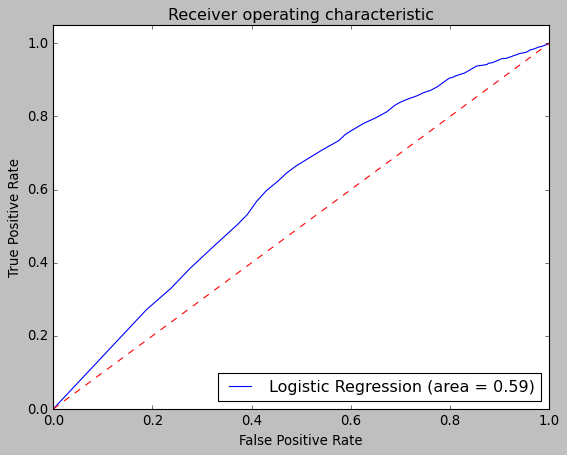

In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

### We are going to repeat the analysis but session wise.
###

In [33]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# starting from the begining

coef = []
accuracy_score = []
df = df1[['trial','state', 'switch', 'stimTrial', 'rewarded','choice', 'correct','t1Rwd','t2Rwd','t3Rwd','animal_date','targOn','targAcq','rt']]
df = df[df['correct'] == 1]
df = df[df['rt'] >0.1]
prob_r = np.fromfile('./exp_probability_kirk', dtype='int16')
df['explore'] = np.where(df['state'] == 1, 1, 0)
df['y'] = prob_r

rwd = np.array(df['rewarded'].values) # create an array of rewards
rwd = np.pad(rwd, (5, 0), 'constant', constant_values=(0.0)) #pad them with 5 zeros for first trial
x = rwd[:-5] # and then take the rewards till the last 5
for i in range(1,5):
    x = np.vstack((x,rwd[(i):(len(rwd)-5+i)])) # stack the rewards for the previous 5 trials
x = x.T
x = np.hstack((x,1-df['explore'].values.reshape(-1,1))) # add the explore column

# P.S. --> For now it is fine, but for changes in matrix alwyas make sure it is matching to what you thought by printing some of it

df['training_x'] = list(x) # add the input matrix to the dataframe

# Now remove the stimulated trials

df = df[df['stimTrial'] == 0]


dates = list(set(df['animal_date'].values))
for date in dates:
    df_date = df[df['animal_date'] == date]
    x = np.array(df_date['training_x'].values.tolist())
    y = 1-df_date['y'].values
    
    x,y = sklearn.utils.shuffle(x,y , random_state=73)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=73)
    logreg = LogisticRegression( random_state=0, class_weight = 'balanced')
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

    '''
    We are going to store the coefficients of the logistic regression
    '''
    coef.append(logreg.coef_)
    accuracy_score.append(logreg.score(X_test, y_test))

[0. 0. 0. 0. 0. 0.]
Accuracy of logistic regression classifier on test set: 0.51
Accuracy of logistic regression classifier on test set: 0.56
Accuracy of logistic regression classifier on test set: 0.56
Accuracy of logistic regression classifier on test set: 0.58
Accuracy of logistic regression classifier on test set: 0.59
Accuracy of logistic regression classifier on test set: 0.51
Accuracy of logistic regression classifier on test set: 0.51
Accuracy of logistic regression classifier on test set: 0.58
Accuracy of logistic regression classifier on test set: 0.54
Accuracy of logistic regression classifier on test set: 0.65
Accuracy of logistic regression classifier on test set: 0.58
Accuracy of logistic regression classifier on test set: 0.60
Accuracy of logistic regression classifier on test set: 0.54
Accuracy of logistic regression classifier on test set: 0.55
Accuracy of logistic regression classifier on test set: 0.52
Accuracy of logistic regression classifier on test set: 0.60
Accu

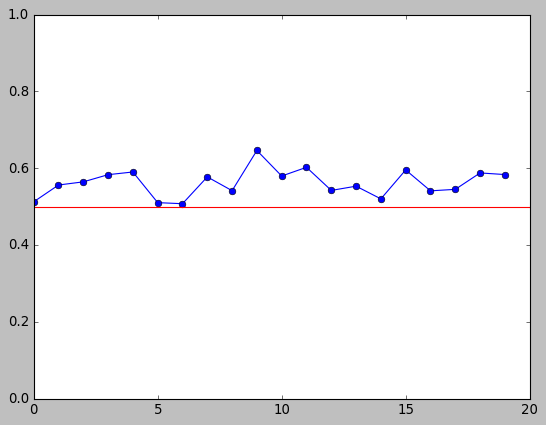

In [31]:
# lets plot the accuracy score
plt.plot(accuracy_score, '-o')
plt.ylim(0,1)
plt.hlines(0.5,0, len(accuracy_score), color = 'r')

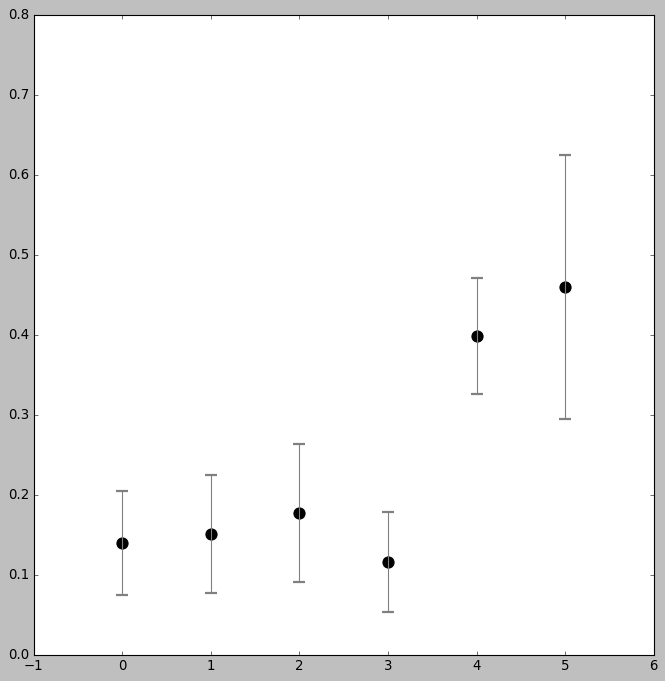

In [70]:
'''
Here We will plot a nice scientific, colorful scatter plot of the coefficients with std error
x axis will be the reward for the previous 5 trials and state
'''
coef = np.array(coef)
real_coef = np.mean(coef, axis = 0)
error = np.std(coef, axis = 0)
plt.figure(figsize = (10,10))
plt.scatter(np.arange(0,6), real_coef[0,:] , color = 'black', s = 100)
# put error bars
plt.errorbar(np.arange(0,6), real_coef[0,:] , yerr = error[0,:]/2, color = 'grey', linestyle = 'None', capsize = 5, capthick = 2)
plt.ylim(0,0.8)
plt.savefig('weight_effect.svg')